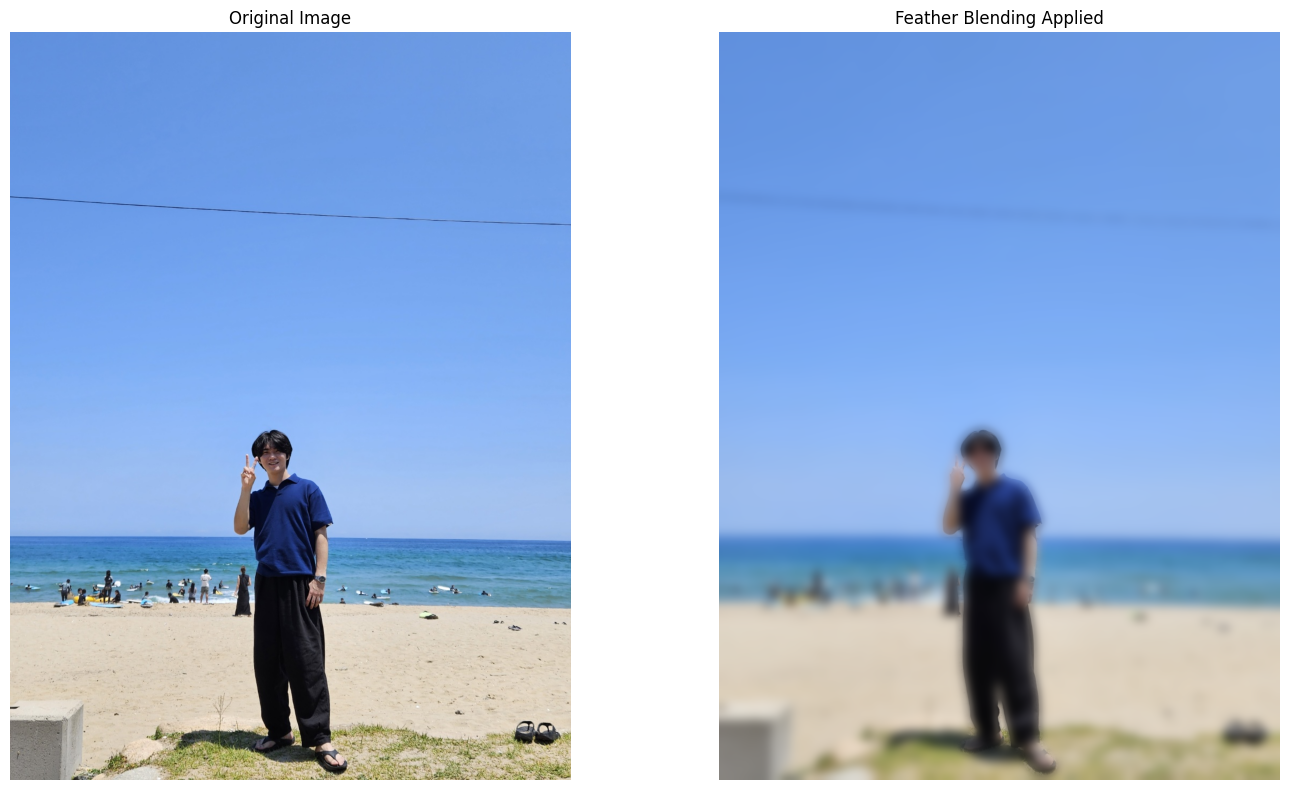

In [4]:
import os
import cv2
import numpy as np
import torch
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image
import matplotlib.pyplot as plt
from skimage import measure  # 연결된 컴포넌트 분석을 위한 모듈

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# [STEP 0] 이미지 로드
img_path = os.path.join(os.getenv('USERPROFILE'), 'Desktop', 'aiffel', 'segmetation', 'images', 'image.png')
img_orig = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

# [STEP 1] DeepLabv3로 인물 마스크 생성 후 가장 큰 인물만 선택
def get_largest_person_mask(image_bgr):
    model = deeplabv3_resnet101(pretrained=True).to(device).eval()
    transform = Compose([
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = transform(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)['out'][0]
        mask = output.argmax(0).byte().cpu().numpy()
    
    # 인물 클래스(15)에 해당하는 마스크 추출
    person_mask = (mask == 15).astype(np.uint8)
    
    # 연결된 컴포넌트 레이블링으로 서로 다른 인물 구분
    labels = measure.label(person_mask)
    regions = measure.regionprops(labels)
    
    if not regions:  # 인물이 없는 경우
        return np.zeros_like(person_mask)
    
    # 가장 큰 영역(인물) 선택
    largest_region = max(regions, key=lambda r: r.area)
    largest_person_mask = np.zeros_like(person_mask)
    largest_person_mask[labels == largest_region.label] = 1
    
    # 마스크 후처리로 잡음 제거 및 경계 부드럽게
    kernel = np.ones((5, 5), np.uint8)
    refined_mask = cv2.morphologyEx(largest_person_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel) * 255
    
    return refined_mask

# 마스크 생성 및 처리
mask = get_largest_person_mask(img_orig)
mask_blur = cv2.GaussianBlur(mask, (31, 31), 0)

# Core, Feather, Background 영역 분리 - Feather 영역 확장
core_mask = (mask_blur > 180).astype(np.uint8) * 255
feather_mask = ((mask_blur > 30) & (mask_blur <= 200)).astype(np.uint8) * 255  # Feather는 경계 블렌딩 영역 확장
bg_mask = (mask_blur <= 30).astype(np.uint8) * 255

# 거리 기반 그라데이션 알파 맵 생성 - 점진적 블렌딩을 위해
def create_gradient_alpha_map(feather_mask):
    dist_transform = cv2.distanceTransform((feather_mask > 0).astype(np.uint8), cv2.DIST_L2, 5)
    max_distance = np.max(dist_transform)
    
    # 거리 값을 기반으로 알파 맵 생성 (경계에서 멀수록 값이 크게)
    alpha_map = dist_transform / max_distance
    
    # 알파 맵을 부드럽게 만들기 위한 가우시안 블러 적용
    alpha_map_smoothed = cv2.GaussianBlur(alpha_map, (21, 21), 0)
    
    return alpha_map_smoothed

# 거리 기반 알파 맵 생성
alpha_map = create_gradient_alpha_map(feather_mask)

# [STEP 2] MiDaS로 depth map 생성 및 개선
def create_improved_alpha_map(mask, core_mask):
    # 인물 전체 마스크
    person_mask = (mask > 0).astype(np.uint8) * 255
    
    # 경계 추출
    edges = cv2.Canny(person_mask, 100, 200)
    dilated_edges = cv2.dilate(edges, np.ones((5,5), np.uint8), iterations=2)
    
    # 경계 주변만 블렌딩 (나머지는 0 또는 1로 고정)
    dist_from_edge = cv2.distanceTransform(255 - dilated_edges, cv2.DIST_L2, 5)
    edge_alpha = np.exp(-dist_from_edge / 10.0)  # 경계에서 점점 감소하는 함수
    
    # 인물 내부는 무조건 1, 외부는 점진적으로 0으로
    alpha_map = np.zeros_like(mask, dtype=np.float32)
    alpha_map[person_mask > 0] = 1.0
    
    # 경계 부분만 부드럽게 처리
    blend_width = 10  # 픽셀 단위 블렌딩 폭
    border_region = (dist_from_edge < blend_width) & (person_mask == 0)
    alpha_map[border_region] = 1.0 - (dist_from_edge[border_region] / blend_width)
    
    return alpha_map

# [STEP 3] 개선된 블러 및 블렌딩 적용 - 점진적 Feather Blending 활용
def apply_feather_blur(img, alpha_map):
    # 단순 블러 적용
    blurred = cv2.GaussianBlur(img, (61, 61), 0)
    
    # 알파 맵 3채널로 변환
    alpha_3ch = np.repeat(alpha_map[:, :, np.newaxis], 3, axis=2)
    
    # 경계 보존 블렌딩 (가이드 필터의 강도 감소)
    blended = img * alpha_3ch + blurred * (1 - alpha_3ch)
    
    return blended.astype(np.uint8)

final_img = apply_feather_blur(img_orig, alpha_map)

# 결과 시각화 - 원본과 결과 비교
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_orig.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(final_img.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title("Feather Blending Applied")
plt.axis('off')

plt.tight_layout()
plt.show()
